<a href="https://colab.research.google.com/github/Code-Trees/Cifar10/blob/main/Centroid_calculation_Imagenet_KNN_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Interactive cell

In [107]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import warnings
warnings.filterwarnings("ignore")

In [139]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.collections import PatchCollection
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer

Downloading the Data

In [4]:
# !wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
# !unzip 'annotations_trainval2017.zip'

In [5]:
#Read COCO JSON File
fptr = open('annotations/instances_train2017.json')
data = json.load(fptr)
print(data.keys())

dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])


Extracting Informations from json

In [109]:
Image_name = [i['file_name'] for i in data['images']]
Image_id = [i['id'] for i in data['images']]
Image_height = [i['height'] for i in data['images']]
Image_width = [i['width'] for i in data['images']]

In [110]:
l_id =[]
l_name = []
for i in data['categories']:
    l_id.append(i['id'])
    l_name.append(i['name'])

In [111]:
B_id = []
B_x = []
B_y = []
B_width= []
B_height =[]
B_category = []
for i in data['annotations']:
    B_id.append(i['image_id'])
    B_x.append(i['bbox'][0])
    B_y.append(i['bbox'][1])
    B_width.append(i['bbox'][2])
    B_height.append(i['bbox'][3])
    B_category.append(i['category_id'])

Creating DataFrames 

In [112]:
df1 = pd.DataFrame({'Image_name':Image_name,'Image_id':Image_id,'Image_height':Image_height,'Image_width':Image_width})

In [113]:
df2 = pd.DataFrame({'B_id':B_id,'B_x':B_x,'B_y':B_y,'B_width':B_width,'B_height':B_height,'B_category':B_category})

In [114]:
df3 = pd.DataFrame({
    'l_id':l_id,'l_name':l_name
})

Merging All DataFrames 

In [116]:
final_df = pd.merge(df1,df2,left_on='Image_id',right_on = 'B_id',how = 'inner')

In [117]:
final_df.sample(2)

,Image_name,Image_id,Image_height,Image_width,B_id,B_x,B_y,B_width,B_height,B_category
753699,000000509210.jpg,509210,428,640,509210,104.26,282.94,72.10,20.84,84
475048,000000479749.jpg,479749,478,640,479749,0.68,1.38,98.65,93.51,1


In [118]:
final_df2  = pd.merge(final_df,df3,left_on = 'B_category',right_on ='l_id',how = 'inner')

In [119]:
final_df2.shape

(860001, 12)

Data Check

In [122]:
final_df2.isnull().sum()
final_df2.shape

Image_name      0
Image_id        0
Image_height    0
Image_width     0
B_id            0
B_x             0
B_y             0
B_width         0
B_height        0
B_category      0
l_id            0
l_name          0
dtype: int64

(860001, 12)

In [121]:
final_df2.columns
final_df2.sample(2)

Index(['Image_name', 'Image_id', 'Image_height', 'Image_width', 'B_id', 'B_x',
       'B_y', 'B_width', 'B_height', 'B_category', 'l_id', 'l_name'],
      dtype='object')

,Image_name,Image_id,Image_height,Image_width,B_id,B_x,B_y,B_width,B_height,B_category,l_id,l_name
234146,000000125464.jpg,125464,276,500,125464,230.16,149.10,32.91,100.99,1,1,person
271630,000000377832.jpg,377832,427,640,377832,468.06,290.95,29.06,71.64,2,2,bicycle


Filtering Needfull Columns

In [123]:
final_df2 = final_df2[['Image_name','Image_id','B_category','l_name' , 'Image_width','Image_height', 'B_x', 'B_y', 'B_width','B_height']]

In [124]:
final_df2.head()

,Image_name,Image_id,B_category,l_name,Image_width,Image_height,B_x,B_y,B_width,B_height
0,000000391895.jpg,391895,4,motorcycle,640,360,359.17,146.17,112.45,213.57
1,000000321107.jpg,321107,4,motorcycle,269,480,132.10,90.53,43.77,65.99
2,000000232262.jpg,232262,4,motorcycle,640,427,28.49,224.45,25.60,32.82
3,000000061181.jpg,61181,4,motorcycle,500,321,389.31,179.02,9.13,14.36
4,000000097434.jpg,97434,4,motorcycle,640,266,368.02,57.52,259.09,169.51


EDA

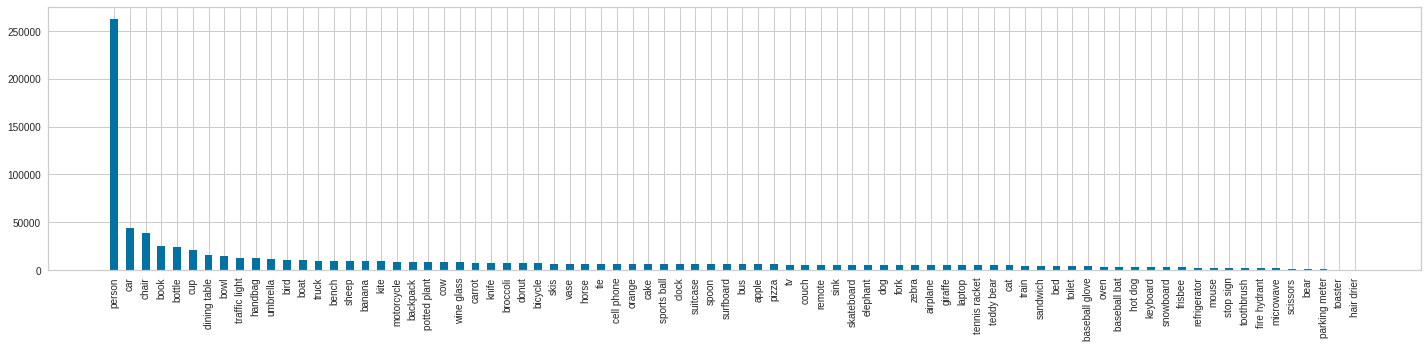

In [125]:
_ = plt.subplots(figsize = (20,5))
_ = final_df2.l_name.value_counts().plot(kind = 'bar',)
_ = plt.autoscale(enable=True) 
_ = plt.tight_layout()

Custom Normalization and Features (finding Centorid of BBox)

In [126]:
final_df2['Centroid_x'] = final_df2['B_x'] + (final_df2['B_width']/2)
final_df2['Centroid_y'] = final_df2['B_y'] + (final_df2['B_height']/2)

Check

In [127]:
final_df2[final_df2.Image_name == '000000391895.jpg']

,Image_name,Image_id,B_category,l_name,Image_width,Image_height,B_x,B_y,B_width,B_height,Centroid_x,Centroid_y
0,000000391895.jpg,391895,4,motorcycle,640,360,359.17,146.17,112.45,213.57,415.395,252.955
8725,000000391895.jpg,391895,1,person,640,360,339.88,22.16,153.88,300.73,416.820,172.525
8726,000000391895.jpg,391895,1,person,640,360,471.64,172.82,35.92,48.10,489.600,196.870
271190,000000391895.jpg,391895,2,bicycle,640,360,486.01,183.31,30.63,34.98,501.325,200.800


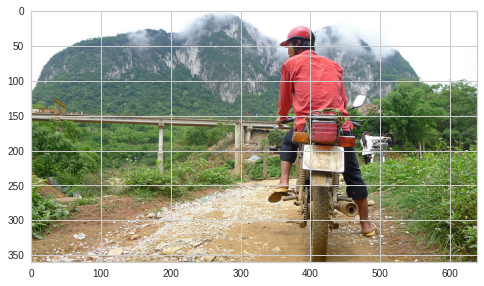

In [130]:
img = plt.imread('000000391895.jpeg')
plt.imshow(img)

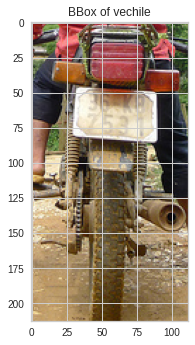

In [132]:
# im = img[146:359,359:471]
im = img[146:359,359:471]
_ = plt.imshow(im)
_= plt.title('BBox of vechile')

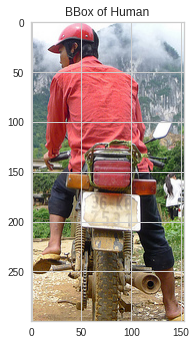

In [134]:
# im = img[146:359,359:471]
im = img[22:322,339:492]
_ = plt.imshow(im)
_= plt.title('BBox of Human')

Normalizing The BOndingBoxes

In [135]:
final_df2.head()
final_df2.iloc[:,4:] = final_df2.iloc[:,4:].astype(float)

,Image_name,Image_id,B_category,l_name,Image_width,Image_height,B_x,B_y,B_width,B_height,Centroid_x,Centroid_y
0,000000391895.jpg,391895,4,motorcycle,640,360,359.17,146.17,112.45,213.57,415.395,252.955
1,000000321107.jpg,321107,4,motorcycle,269,480,132.10,90.53,43.77,65.99,153.985,123.525
2,000000232262.jpg,232262,4,motorcycle,640,427,28.49,224.45,25.60,32.82,41.290,240.860
3,000000061181.jpg,61181,4,motorcycle,500,321,389.31,179.02,9.13,14.36,393.875,186.200
4,000000097434.jpg,97434,4,motorcycle,640,266,368.02,57.52,259.09,169.51,497.565,142.275


In [136]:
final_df_normalize = final_df2.copy()

In [137]:
final_df_normalize['B_width'] = final_df_normalize.B_width/ final_df_normalize.Image_width
final_df_normalize['Centroid_x'] = final_df_normalize.Centroid_x/ final_df_normalize.Image_width
# final_df_normalize['Image_width'] = final_df_normalize.Image_width/ final_df_normalize.Image_width

In [138]:
final_df_normalize['B_height'] = final_df_normalize.B_height/ final_df_normalize.Image_height
final_df_normalize['Centroid_y'] = final_df_normalize.Centroid_y/ final_df_normalize.Image_height
# final_df_normalize['Image_height'] = final_df_normalize.Image_height/ final_df_normalize.Image_height

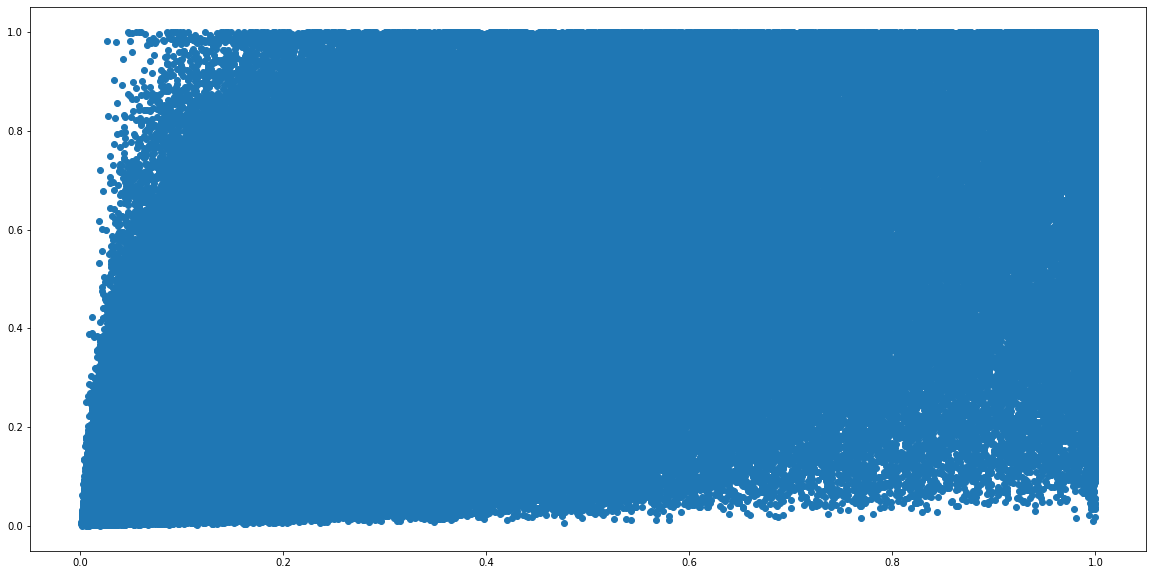

In [37]:
_ = plt.subplots(figsize = (20,10))
_ = plt.scatter(x = final_df_normalize['B_width'],y = final_df_normalize['B_height'])

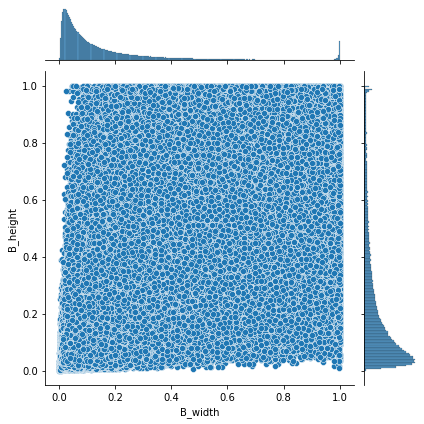

In [38]:
_ = sns.jointplot(final_df_normalize['B_width'] , final_df_normalize['B_height'])

KNN Class and plots 

In [140]:
class Run_clustering():
    def __init__(self,data,Log = False,n_clusters = 1,epochs=50,SEED = 43):
        self.n_clusters = n_clusters
        
        if Log == True:
            self.data = np.log(data)
        else:
            self.data = data

        self.iterations = epochs
        self.SEED = SEED
        

    def run(self):
        self.model,self.pred_y = self.Kmeans(self.k)
        # self.view(km = self.model,data =self.data)
        score = silhouette_score(self.data, self.model.labels_, metric='euclidean')
        print(f'Silohouette Score for {self.k} cluster(s) is {score} ')
        return self.model,self.model.cluster_centers_,self.model.inertia_

    def Kmeans(self,k):
        kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=self.iterations, n_init=10, random_state=self.SEED)
        pred_y = kmeans.fit_predict(self.data)
        return kmeans,pred_y
    
    def view(self):
        _ = sns.pairplot(self.data,diag_kind = 'kde',)
        
    def find_k(self):
        model = KMeans()
        visualizer = KElbowVisualizer(model ,k=(1,self.n_clusters))
        visualizer.fit(self.data)
        visualizer.show()
        self.k = visualizer.elbow_value_
    
    def plot_anchor_boxes(self):
        xdata = np.array([0.5]*len(self.model.cluster_centers_))
        ydata = np.array([0.5]*len(self.model.cluster_centers_))

        xerror = np.array([list(np.exp(self.model.cluster_centers_[:, 0])/2)]*2)
        yerror = np.array([list(np.exp(self.model.cluster_centers_[:, 1])/2)]*2)

        errorboxes = []

        for x, y, xe, ye in zip(xdata, ydata, xerror.T, yerror.T):
            rect = plt.Rectangle((x - xe[0], y - ye[0]), xe.sum(), ye.sum())
            errorboxes.append(rect)

        pc = PatchCollection(errorboxes, facecolor='None', alpha=1, edgecolor='blue')
        fig, ax = plt.subplots(1)

        ax.add_collection(pc)
        plt.title(f'Anchor Boxes for k = {self.model.cluster_centers_}')
        artists = plt.errorbar(xdata, ydata, xerr=xerror, yerr=yerror, fmt='None', ecolor='None')


In [141]:
sample_data =final_df_normalize[['B_width','B_height']].sample(25000)
cluster = Run_clustering(sample_data,Log = False,n_clusters=10)

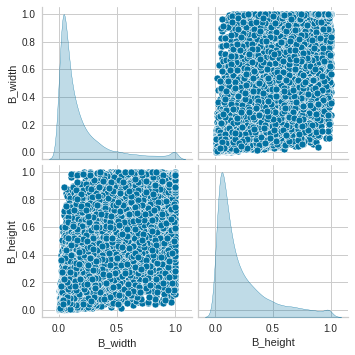

In [142]:
cluster.view()

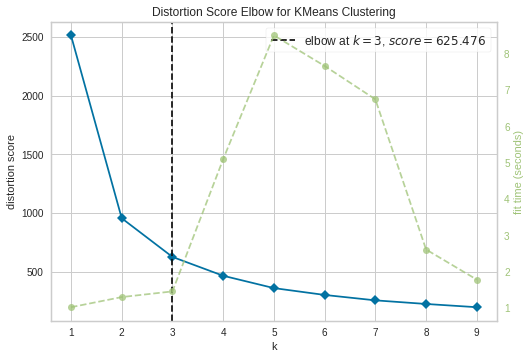

In [143]:
cluster.find_k()

In [144]:
model,cluster_centers_,inertia_ =cluster.run()

Silohouette Score for 3 cluster(s) is 0.5749110198912685 


IOU (Intersection over Union)

In [145]:
def IOU(x,centroids):
        '''
        :param x: a ground truth w,h
            :param centroids: collection of anchor w,h[(w,h),(),...], total k
            :return: a set of IoU values ​​for a single ground truth box and all k anchor boxes
        '''
        IoUs = []
        
        for centroid in centroids:
                w, h = x # ground truth's w, h
                c_w,c_h = centroid #anchorw,h
                # print(c_w,c_h)
                if c_w>=w and c_h>=h: #anchor surrounded by ground truth
                  iou = w*h/(c_w*c_h)
                elif c_w>=w and c_h<=h: #anchor
                  iou = w*c_h/(w*h + (c_w-w)*c_h)
                elif c_w<=w and c_h>=h: #anchor elongated
                  iou = c_w*h/(w*h + c_w*(c_h-h))
                else: #ground truth surrounded by anchor means both w,h are bigger than c_w and c_h respectively
                  iou = (c_w*c_h)/(w*h)
                IoUs.append(iou) # will become (k,) shape
        return np.array(IoUs)

In [146]:
IOU(np.array(sample_data)[0],cluster_centers_)

array([0.06894411, 0.00109269, 0.00477337])

Final ancherBox Found

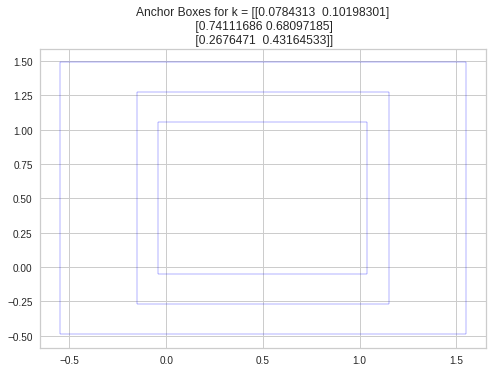

In [148]:
cluster.plot_anchor_boxes()